In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# 需要日報酬率跟fama殘差矩陣
residual_df = pd.read_csv("2009_2025_fama_residual.csv", index_col=0, parse_dates=True)
return_raw = pd.read_excel("Return20240229.xlsx")

return_raw.columns = return_raw.columns.str.strip()
return_raw["年月日"] = pd.to_datetime(return_raw["年月日"])
return_raw["股票"] = return_raw["代號"].astype(str) + " " + return_raw["名稱"]
pivot_return = return_raw.pivot(index="年月日", columns="股票", values="日報酬率 %").sort_index()
residual_df.index = pd.to_datetime(residual_df.index)

#切割
train_residual = residual_df[residual_df.index < "2024-02-29"]
test_residual = residual_df[residual_df.index >= "2024-02-29"]
test_return = pivot_return[pivot_return.index >= "2024-02-29"]

#訓練集
lookback = 30
X_list, y_list = [], []

for stock in train_residual.columns:
    series = train_residual[stock].dropna().values
    if len(series) <= lookback:
        continue
    for i in range(lookback, len(series) - 1):
        X_window = series[i - lookback:i]
        y_target = series[i]
        X_list.append(X_window)
        y_list.append(y_target)

X = np.array(X_list).reshape(-1, lookback, 1)
y = np.array(y_list).reshape(-1)

#測試集
X_test_list, y_test_list, meta_list = [], [], []

for stock in test_residual.columns:
    series = test_residual[stock].dropna().values
    dates = test_residual[stock].dropna().index
    if len(series) <= lookback:
        continue
    for i in range(lookback, len(series) - 1):
        X_window = series[i - lookback:i]
        y_target = series[i]
        X_test_list.append(X_window)
        y_test_list.append(y_target)
        meta_list.append((dates[i], stock))

X_test = np.array(X_test_list).reshape(-1, lookback, 1)
y_test = np.array(y_test_list).reshape(-1)

#機器學習與損失函數
def sharpe_loss(y_true, y_pred):
    pnl = y_pred * y_true
    mean = tf.reduce_mean(pnl)
    std = tf.math.reduce_std(pnl)
    sharpe = mean / (std + 1e-6)
    return -sharpe

def build_model(input_len=30, cnn_filters=8, attn_heads=2, ff_dim=16):
    inp = layers.Input(shape=(input_len, 1))
    x = layers.Conv1D(filters=cnn_filters, kernel_size=3, padding='same', activation='relu')(inp)
    attn_out = layers.MultiHeadAttention(num_heads=attn_heads, key_dim=cnn_filters)(x, x)
    x = layers.Add()([x, attn_out])
    x = layers.LayerNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(ff_dim, activation='relu')(x)
    out = layers.Dense(1)(x)
    model = models.Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss=sharpe_loss)
    return model

#模型訓練與預測
model = build_model()
model.fit(X, y, epochs=10, batch_size=64)
y_pred = model.predict(X_test).flatten()

Epoch 1/10
50653/50653 ━━━━━━━━━━━━━━━━━━━━ 173s 3ms/step - loss: -0.0080
Epoch 2/10
50653/50653 ━━━━━━━━━━━━━━━━━━━━ 172s 3ms/step - loss: -0.0267
Epoch 3/10
50653/50653 ━━━━━━━━━━━━━━━━━━━━ 179s 4ms/step - loss: -0.0275
Epoch 4/10
50653/50653 ━━━━━━━━━━━━━━━━━━━━ 168s 3ms/step - loss: -0.0307
Epoch 5/10
50653/50653 ━━━━━━━━━━━━━━━━━━━━ 188s 4ms/step - loss: -0.0308
Epoch 6/10
50653/50653 ━━━━━━━━━━━━━━━━━━━━ 164s 3ms/step - loss: -0.0322
Epoch 7/10
50653/50653 ━━━━━━━━━━━━━━━━━━━━ 176s 3ms/step - loss: -0.0317
Epoch 8/10
50653/50653 ━━━━━━━━━━━━━━━━━━━━ 172s 3ms/step - loss: -0.0332
Epoch 9/10
50653/50653 ━━━━━━━━━━━━━━━━━━━━ 173s 3ms/step - loss: -0.0344
Epoch 10/10
50653/50653 ━━━━━━━━━━━━━━━━━━━━ 164s 3ms/step - loss: -0.0341
8348/8348 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


In [22]:
X_test

array([[[ 1.49982999e-04],
        [ 5.36289539e-03],
        [ 1.30313403e-03],
        ...,
        [ 6.67313175e-03],
        [-8.17982205e-03],
        [-2.48927979e-03]],

       [[ 5.36289539e-03],
        [ 1.30313403e-03],
        [-1.87984591e-03],
        ...,
        [-8.17982205e-03],
        [-2.48927979e-03],
        [ 5.63416137e-03]],

       [[ 1.30313403e-03],
        [-1.87984591e-03],
        [-1.26091773e-03],
        ...,
        [-2.48927979e-03],
        [ 5.63416137e-03],
        [ 1.46814903e-02]],

       ...,

       [[-2.48684384e-04],
        [ 3.26331679e-03],
        [-9.97642768e-05],
        ...,
        [-1.04752459e-02],
        [ 1.16912840e-02],
        [-4.48970122e-03]],

       [[ 3.26331679e-03],
        [-9.97642768e-05],
        [ 3.56426363e-02],
        ...,
        [ 1.16912840e-02],
        [-4.48970122e-03],
        [-1.15729059e-02]],

       [[-9.97642768e-05],
        [ 3.56426363e-02],
        [ 6.18960152e-02],
        ...,
        

In [15]:
pnl_df = pd.DataFrame(meta_list, columns=["date", "stock"])
pnl_df["signal"] = y_pred
pnl_df

,date,stock,signal
0,2024-04-15,1101 台泥,11.270461
1,2024-04-16,1101 台泥,11.278893
2,2024-04-17,1101 台泥,10.260882
3,2024-04-18,1101 台泥,10.153375
4,2024-04-19,1101 台泥,10.220045
...,...,...,...
267112,2025-05-19,9958 世紀鋼,-2.635478
267113,2025-05-20,9958 世紀鋼,-2.263684
267114,2025-05-21,9958 世紀鋼,-2.254185
267115,2025-05-22,9958 世紀鋼,-2.193598


In [24]:
test_return

股票,1101 台泥,1102 亞泥,1103 嘉泥,1104 環泥,1108 幸福,1109 信大,1110 東泥,1201 味全,1203 味王,1210 大成,...,9939 宏全,9940 信義,9941 裕融,9942 茂順,9943 好樂迪,9944 新麗,9945 潤泰新,9946 三發地產,9955 佳龍,9958 世紀鋼
年月日,,,,,,,,,,,,,,,,,,,,,
2024-02-29,0.7849,0.8728,-0.8403,1.5385,1.2862,1.1331,-0.5556,0.8000,0.0000,-0.1709,...,-0.3425,-0.5068,1.2232,1.1194,0.6682,0.0000,0.4144,-0.8602,1.2903,3.2064
2024-03-01,-0.1558,-0.7417,0.5650,0.1684,0.3175,-0.2801,-0.2793,0.7937,0.1838,0.8562,...,0.3436,0.1698,0.0000,0.7380,0.3319,0.2469,-0.9629,0.6508,-0.8493,0.9709
2024-03-04,0.0000,-0.2491,-0.5618,3.0252,0.3165,-0.2809,0.8403,0.2625,-1.2844,-0.3396,...,0.0000,-0.1695,-0.6042,-0.3663,0.0000,-0.2463,-0.9722,4.0948,2.3555,-2.8846
2024-03-05,-0.1560,0.0000,-0.8475,0.8157,1.8927,0.8451,-0.2778,-0.7853,-1.1152,2.7257,...,1.7123,-0.3396,-0.3040,0.3676,0.5513,0.2469,0.0000,2.2774,1.4644,-1.3861
2024-03-06,0.0000,-0.1248,0.2849,0.9709,0.6192,0.0000,0.0000,0.0000,-0.5639,0.1658,...,0.6734,0.1704,0.6098,0.7326,0.5482,0.2463,1.4025,1.8219,1.8557,-0.4016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-20,1.1745,2.0362,0.3155,0.5102,0.3279,1.4577,2.9777,0.2950,1.4742,1.4308,...,-0.6536,-0.3559,0.0000,0.4237,0.2567,-0.5814,0.4926,1.5075,-0.1718,0.2786
2025-05-21,0.4975,-0.6652,1.5723,0.8460,-0.3268,0.2874,0.4819,0.5882,-0.2421,0.0000,...,0.0000,0.1786,0.8696,0.4219,0.8963,0.2924,1.1438,2.9703,1.5491,-0.2778
2025-05-22,-0.9901,-3.2366,-0.9288,-0.3356,0.3279,-0.5731,0.4796,-0.2924,-0.3641,0.1567,...,-0.3289,-0.3565,-1.7241,-0.8403,-0.2538,-0.2915,-2.2617,-0.9615,1.6949,0.5571


In [20]:
returns_flat = []
for date, stock in zip(pnl_df["date"], pnl_df["stock"]):
    if stock in test_return.columns and date in test_return.index:
        returns_flat.append(test_return.loc[date, stock] / 100)
    else:
        returns_flat.append(np.nan)

In [21]:
returns_flat

[np.float64(0.004658),
 np.float64(0.003091),
 np.float64(0.006162999999999999),
 np.float64(0.0015310000000000002),
 np.float64(-0.021407),
 np.float64(0.01875),
 np.float64(-0.0076690000000000005),
 np.float64(-0.006182),
 np.float64(-0.004666),
 np.float64(-0.00625),
 np.float64(0.017296),
 np.float64(-0.009274),
 np.float64(0.0078000000000000005),
 np.float64(0.003096),
 np.float64(0.018519),
 np.float64(0.0060609999999999995),
 np.float64(-0.0030120000000000004),
 np.float64(-0.013595),
 np.float64(0.019908),
 np.float64(0.012012),
 np.float64(-0.010386),
 np.float64(-0.0014990000000000001),
 np.float64(0.009009),
 np.float64(0.008929),
 np.float64(-0.001475),
 np.float64(-0.014771000000000001),
 np.float64(0.029984999999999998),
 np.float64(-0.010188999999999998),
 np.float64(0.001471),
 np.float64(-0.007342),
 np.float64(0.004438),
 np.float64(-0.022091),
 np.float64(-0.010542000000000001),
 np.float64(0.004566),
 np.float64(0.0),
 np.float64(-0.009091),
 np.float64(0.0),
 np.fl

In [25]:
pnl_df["return"] = returns_flat
pnl_df

,date,stock,signal,return
0,2024-04-15,1101 台泥,11.270461,0.004658
1,2024-04-16,1101 台泥,11.278893,0.003091
2,2024-04-17,1101 台泥,10.260882,0.006163
3,2024-04-18,1101 台泥,10.153375,0.001531
4,2024-04-19,1101 台泥,10.220045,-0.021407
...,...,...,...,...
267112,2025-05-19,9958 世紀鋼,-2.635478,0.008427
267113,2025-05-20,9958 世紀鋼,-2.263684,0.002786
267114,2025-05-21,9958 世紀鋼,-2.254185,-0.002778
267115,2025-05-22,9958 世紀鋼,-2.193598,0.005571


In [26]:
top_n_df = pnl_df.groupby("date")

In [44]:
top_n_df.get_group(pd.Timestamp("2024-04-15")).sort_values("signal", ascending=False)

,date,stock,signal,return
16409,2024-04-15,1423 利華,13.116922,0.000000
131541,2024-04-15,2904 匯僑,12.900140,0.000000
63753,2024-04-15,2108 南帝,12.895864,-0.011905
118629,2024-04-15,2642 宅配通,12.809849,-0.001325
125623,2024-04-15,2849 安泰銀,12.777421,0.003546
...,...,...,...,...
221387,2024-04-15,6491 晶碩,-97.350777,-0.015528
243714,2024-04-15,8112 至上,-97.457603,-0.008083
110021,2024-04-15,2537 聯上發,-98.475060,-0.012461
81507,2024-04-15,2374 佳能,-99.484581,-0.032134


In [42]:
top_5_df = top_n_df.apply(lambda x: x.nlargest(5, "signal")).reset_index(drop=True)

C:\Users\open7\AppData\Local\Temp\ipykernel_39084\3126136248.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_5_df = top_n_df.apply(lambda x: x.nlargest(5, "signal")).reset_index(drop=True)


In [47]:
def norm_pos(s):
    # 若當天 signal 全部加總為 0，就平均分配
    tot = s.sum()
    if tot != 0:
        return s / tot
    return pd.Series([1/len(s)] * len(s), index=s.index)
top_5_df["weight"] = (top_5_df.groupby("date")["signal"].transform(norm_pos))

In [49]:
top_5_df["pnl"] = top_5_df["weight"] * top_5_df["return"]

In [50]:
top_5_df

,date,stock,signal,return,pnl,weight
0,2024-04-15,1423 利華,13.116922,0.000000,0.000000,0.203363
1,2024-04-15,2904 匯僑,12.900140,0.000000,0.000000,0.200002
2,2024-04-15,2108 南帝,12.895864,-0.011905,-0.002380,0.199935
3,2024-04-15,2642 宅配通,12.809849,-0.001325,-0.000263,0.198602
4,2024-04-15,2849 安泰銀,12.777421,0.003546,0.000702,0.198099
...,...,...,...,...,...,...
1340,2025-05-23,1419 新紡,15.532026,0.099112,0.023304,0.235132
1341,2025-05-23,6115 鎰勝,12.951596,0.005780,0.001133,0.196068
1342,2025-05-23,2373 震旦行,12.548856,0.000000,0.000000,0.189971
1343,2025-05-23,6464 台數科,12.523202,0.001241,0.000235,0.189583


In [51]:
# 統計績效指標
daily_pnl = top_5_df.groupby("date")["pnl"].sum()
cumulative_return = (1 + daily_pnl).cumprod()
win_rate = (daily_pnl > 0).sum() / len(daily_pnl)
cum_max = cumulative_return.cummax()
drawdown = cum_max - cumulative_return
max_drawdown = drawdown.max()
mean = daily_pnl.mean()
std = daily_pnl.std()
sharpe = (mean / (std + 1e-8)) * np.sqrt(252)

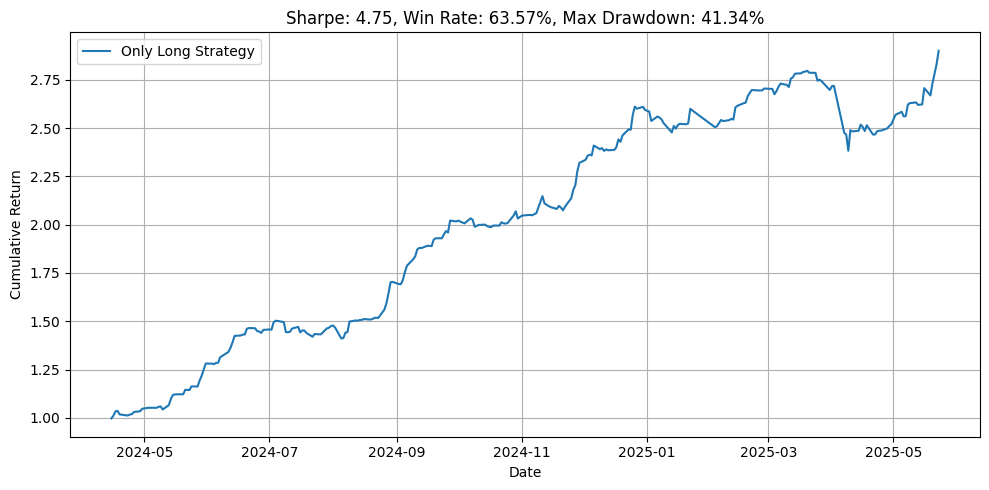

In [53]:
plt.figure(figsize=(10, 5))
plt.plot(cumulative_return, label="Only Long Strategy")
plt.title(f"Sharpe: {sharpe:.2f}, Win Rate: {win_rate:.2%}, Max Drawdown: {max_drawdown:.2%}")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()